# Analysis of EM Algorithm for Hidden Units

This notebook analyses the results from the grid search over hidden cell fractions in the EM algorithm experiment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100

In [2]:
# Path to grid search results
grid_search_dir = Path("/tungstenfs/scratch/gzenke/bedfrory/dp-simulations/activity-fitting/hidden-units-em/grid-search")

# Find all run directories
run_dirs = sorted([d for d in grid_search_dir.iterdir() if d.is_dir() and d.name.startswith("hidden-fraction-")])
print(f"Found {len(run_dirs)} runs:")
for d in run_dirs:
    print(f"  {d.name}")

Found 2 runs:
  hidden-fraction-0.10
  hidden-fraction-0.20


In [3]:
# Load final metrics from the last EM iteration for each run
def get_last_em_iteration(run_dir):
    """Find the last EM iteration directory."""
    em_dirs = sorted([d for d in run_dir.iterdir() if d.is_dir() and d.name.startswith("em_iter_")])
    return em_dirs[-1] if em_dirs else None

def load_em_metrics(run_dir):
    """Load metrics from all EM iterations for a run."""
    em_dirs = sorted([d for d in run_dir.iterdir() if d.is_dir() and d.name.startswith("em_iter_")])
    all_metrics = []
    
    for em_dir in em_dirs:
        metrics_path = em_dir / "training_metrics.csv"
        if metrics_path.exists():
            df = pd.read_csv(metrics_path)
            # Get final row of this EM iteration
            final_row = df.iloc[-1].to_dict()
            all_metrics.append(final_row)
    
    return pd.DataFrame(all_metrics)

# Load data for all runs
all_runs_data = {}
for run_dir in run_dirs:
    match = re.search(r'hidden-fraction-(\d+\.\d+)', run_dir.name)
    if match:
        hidden_frac = float(match.group(1))
        metrics_df = load_em_metrics(run_dir)
        if not metrics_df.empty:
            all_runs_data[hidden_frac] = metrics_df
            print(f"Loaded {len(metrics_df)} EM iterations for hidden_frac={hidden_frac}")

Loaded 9 EM iterations for hidden_frac=0.1
Loaded 10 EM iterations for hidden_frac=0.2


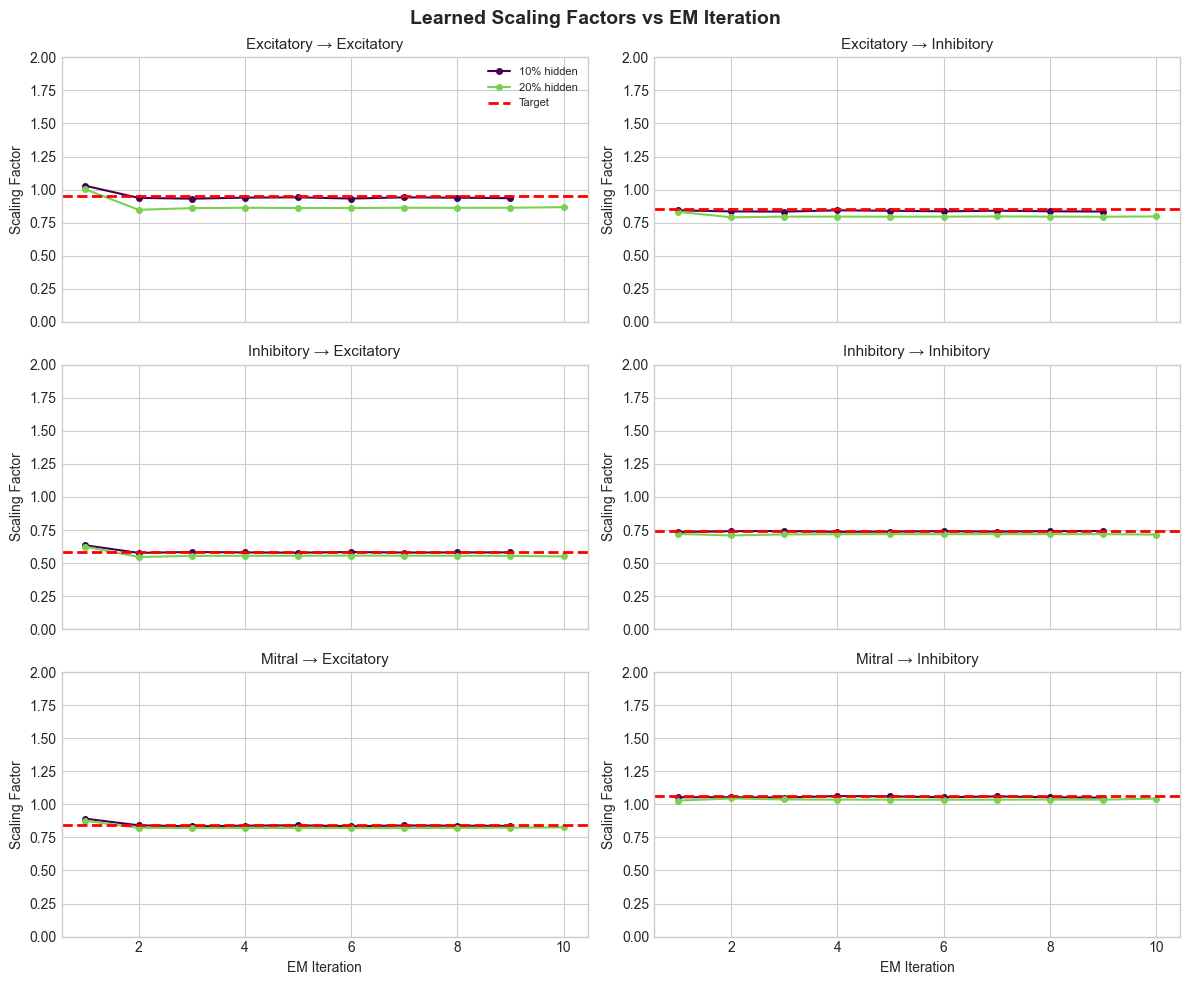

In [4]:
# Plot scaling factors vs EM iteration for each hidden fraction (3x2 subplot)
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)

scaling_factor_pairs = [
    ('excitatory_to_excitatory', 'Excitatory \u2192 Excitatory'),
    ('excitatory_to_inhibitory', 'Excitatory \u2192 Inhibitory'),
    ('inhibitory_to_excitatory', 'Inhibitory \u2192 Excitatory'),
    ('inhibitory_to_inhibitory', 'Inhibitory \u2192 Inhibitory'),
    ('mitral_to_excitatory', 'Mitral \u2192 Excitatory'),
    ('mitral_to_inhibitory', 'Mitral \u2192 Inhibitory'),
]

colors = plt.cm.viridis(np.linspace(0, 0.8, len(all_runs_data)))

for idx, (key, title) in enumerate(scaling_factor_pairs):
    ax = axes.flat[idx]
    
    for (hidden_frac, df), color in zip(sorted(all_runs_data.items()), colors):
        em_iters = df['em/iteration'].values
        values = df[f'scaling_factors/{key}/value'].values
        ax.plot(em_iters, values, 'o-', color=color, markersize=4, label=f'{hidden_frac:.0%} hidden')
    
    # Plot target (from first run, should be same for all)
    first_df = list(all_runs_data.values())[0]
    target = first_df[f'scaling_factors/{key}/target'].iloc[0]
    ax.axhline(y=target, color='red', linestyle='--', linewidth=2, label='Target')
    
    ax.set_title(title, fontsize=11)
    ax.set_ylabel('Scaling Factor')
    ax.set_ylim(0, 2)
    
    if idx >= 4:  # Bottom row
        ax.set_xlabel('EM Iteration')
    
    if idx == 0:
        ax.legend(loc='best', fontsize=8)

plt.suptitle('Learned Scaling Factors vs EM Iteration', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

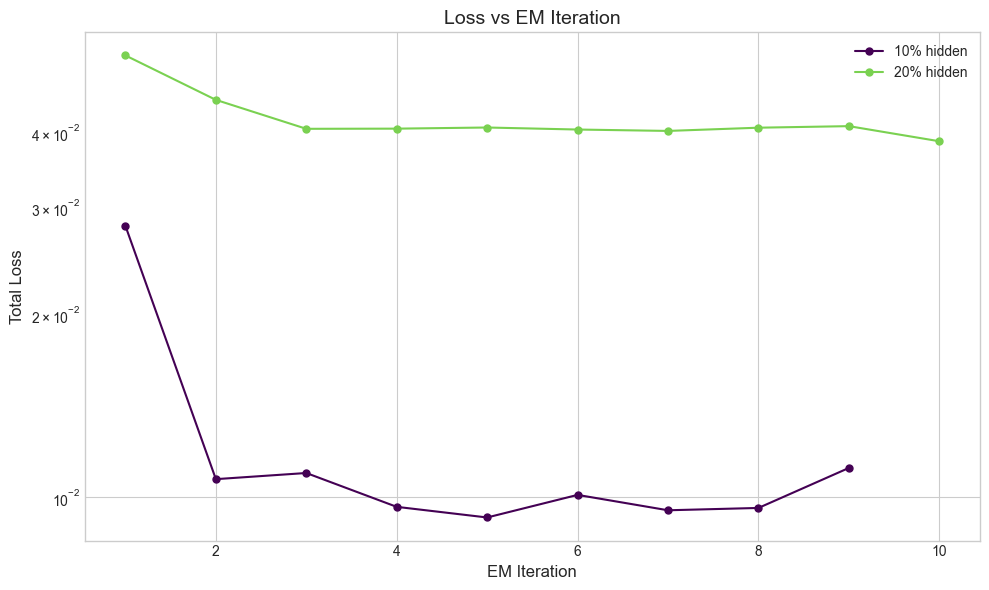

In [5]:
# Plot loss vs EM iteration for each hidden fraction
fig, ax = plt.subplots(figsize=(10, 6))

for (hidden_frac, df), color in zip(sorted(all_runs_data.items()), colors):
    em_iters = df['em/iteration'].values
    loss = df['total_loss'].values
    ax.plot(em_iters, loss, 'o-', color=color, markersize=5, label=f'{hidden_frac:.0%} hidden')

ax.set_xlabel('EM Iteration', fontsize=12)
ax.set_ylabel('Total Loss', fontsize=12)
ax.set_title('Loss vs EM Iteration', fontsize=14)
ax.legend(loc='best')
ax.set_yscale('log')

plt.tight_layout()
plt.show()

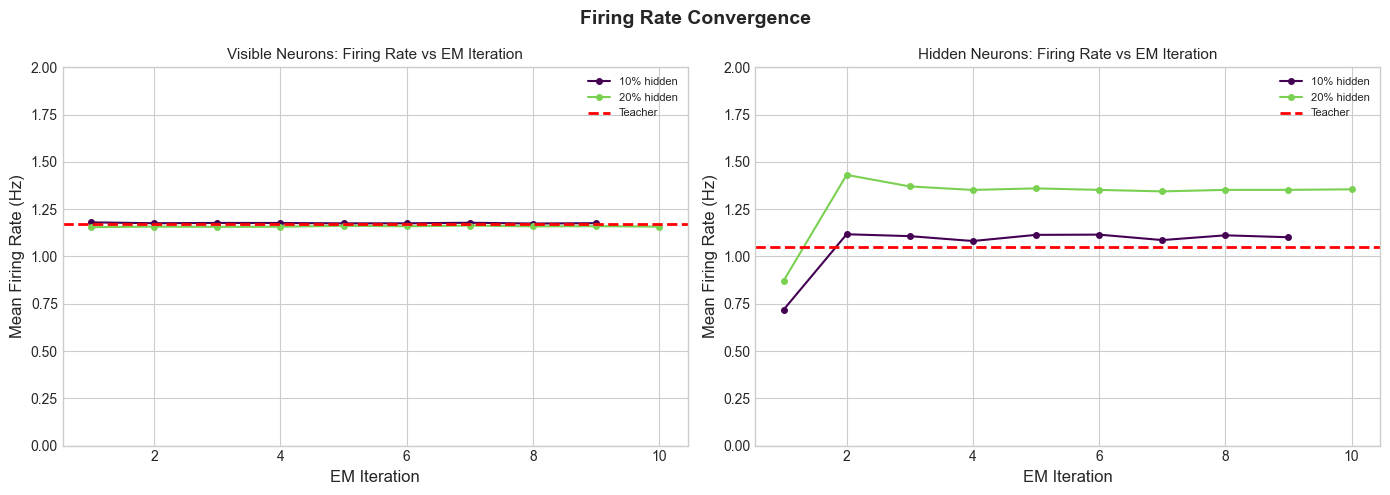

In [6]:
# Plot mean firing rate vs EM iteration (student vs teacher, visible neurons)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Visible neurons
ax = axes[0]
for (hidden_frac, df), color in zip(sorted(all_runs_data.items()), colors):
    em_iters = df['em/iteration'].values
    student_rate = df['firing_rate/student/visible/mean'].values
    ax.plot(em_iters, student_rate, 'o-', color=color, markersize=4, label=f'{hidden_frac:.0%} hidden')

# Teacher reference (should be same across runs)
first_df = list(all_runs_data.values())[0]
teacher_visible_rate = first_df['firing_rate/teacher/visible/mean'].iloc[0]
ax.axhline(y=teacher_visible_rate, color='red', linestyle='--', linewidth=2, label='Teacher')

ax.set_xlabel('EM Iteration', fontsize=12)
ax.set_ylabel('Mean Firing Rate (Hz)', fontsize=12)
ax.set_title('Visible Neurons: Firing Rate vs EM Iteration', fontsize=11)
ax.legend(loc='best', fontsize=8)
ax.set_ylim(0, 2)

# Right: Hidden neurons
ax = axes[1]
for (hidden_frac, df), color in zip(sorted(all_runs_data.items()), colors):
    em_iters = df['em/iteration'].values
    student_rate = df['firing_rate/student/hidden/mean'].values
    ax.plot(em_iters, student_rate, 'o-', color=color, markersize=4, label=f'{hidden_frac:.0%} hidden')

# Teacher reference
teacher_hidden_rate = first_df['firing_rate/teacher/hidden/mean'].iloc[0]
ax.axhline(y=teacher_hidden_rate, color='red', linestyle='--', linewidth=2, label='Teacher')

ax.set_xlabel('EM Iteration', fontsize=12)
ax.set_ylabel('Mean Firing Rate (Hz)', fontsize=12)
ax.set_title('Hidden Neurons: Firing Rate vs EM Iteration', fontsize=11)
ax.legend(loc='best', fontsize=8)
ax.set_ylim(0, 2)

plt.suptitle('Firing Rate Convergence', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

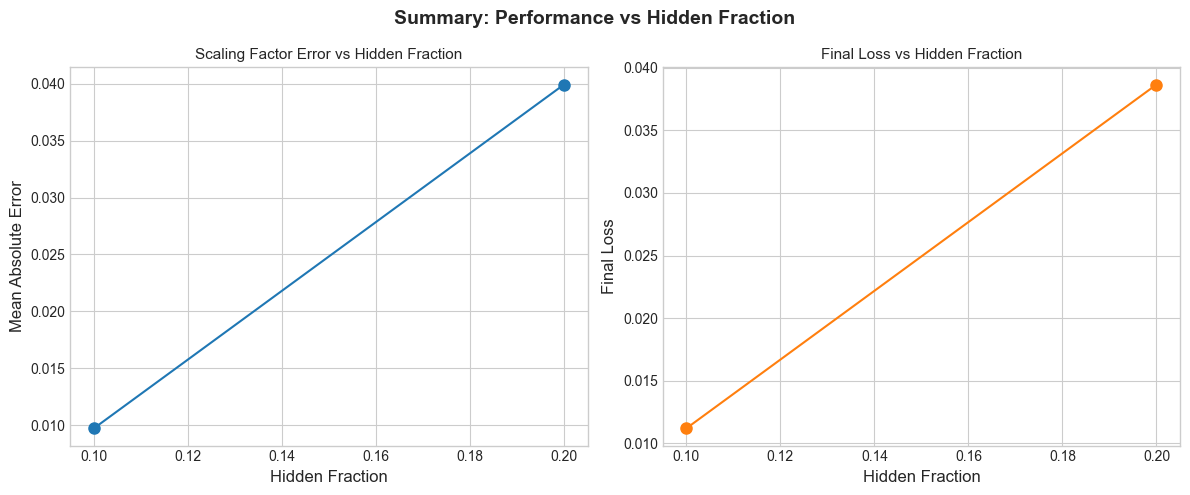


Final Results:
 hidden_fraction  mean_abs_error  final_loss
             0.1        0.009709    0.011185
             0.2        0.039941    0.038668


In [7]:
# Summary: Final scaling factor error vs hidden fraction
final_results = []

for hidden_frac, df in sorted(all_runs_data.items()):
    final_row = df.iloc[-1]
    
    # Compute mean absolute error across all scaling factors
    errors = []
    for key, _ in scaling_factor_pairs:
        value = final_row[f'scaling_factors/{key}/value']
        target = final_row[f'scaling_factors/{key}/target']
        errors.append(abs(value - target))
    
    final_results.append({
        'hidden_fraction': hidden_frac,
        'mean_abs_error': np.mean(errors),
        'final_loss': final_row['total_loss'],
    })

final_df = pd.DataFrame(final_results)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Scaling factor error
ax = axes[0]
ax.plot(final_df['hidden_fraction'], final_df['mean_abs_error'], 'o-', markersize=8, color='C0')
ax.set_xlabel('Hidden Fraction', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Scaling Factor Error vs Hidden Fraction', fontsize=11)

# Right: Final loss
ax = axes[1]
ax.plot(final_df['hidden_fraction'], final_df['final_loss'], 'o-', markersize=8, color='C1')
ax.set_xlabel('Hidden Fraction', fontsize=12)
ax.set_ylabel('Final Loss', fontsize=12)
ax.set_title('Final Loss vs Hidden Fraction', fontsize=11)

plt.suptitle('Summary: Performance vs Hidden Fraction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nFinal Results:")
print(final_df.to_string(index=False))